## Read raw data and generate timestamped graphs

In [1]:
import os
import json
import numpy as np
from matplotlib import pyplot as plt

data_dirname = "/coc/flash5/mpatel377/repos/SLaTe-PRO/data/RoboCraft/rawAnnotated"

list_of_datafiles = json.load(open(os.path.join(data_dirname, "../phase1_train_data.json")))

TIME_START_HHMMSS = "150000"
TIME_END_HHMMSS = "180000"

VERBOSE = True

In [2]:
import os
import json

def time_hhmmss_to_seconds(time_hhmmss):
    return int(time_hhmmss[:2]) * 3600 + int(time_hhmmss[2:4]) * 60 + int(time_hhmmss[4:6])

def time_seconds_to_hhmmss(time_seconds):
    return f"{time_seconds//3600:02d}:{(time_seconds%3600)//60:02d}:{(time_seconds%3600)%60:02d}"

def lowercase_table_name(table_name):
    return table_name.replace("Table", "table").replace(" ", "")

def proc_labels(frame_labels_list):
    def label_name_mods(ln):
        ln = ln.split("_")[0]
        if '|' in ln:
            ln = ln.split('|')[-1]
        return ln
    categories = sorted(list(set([label_name_mods(lab["category"]) for lab in frame_labels_list])))
    return categories

TIME_START_SECONDS = time_hhmmss_to_seconds(TIME_START_HHMMSS)
TIME_END_SECONDS = time_hhmmss_to_seconds(TIME_END_HHMMSS)

def process_frames(data_raw, start_time_hhmmss):
    start_time_seconds = time_hhmmss_to_seconds(start_time_hhmmss)
    timestamped_scene_graphs = {}
    for frame in data_raw:
        timestamp_relative = int(frame["name"].split("_")[-1].split(".")[0])//1000
        timestamp_absolute = start_time_seconds + timestamp_relative
        if timestamp_absolute > TIME_START_SECONDS and timestamp_absolute < TIME_END_SECONDS:
            labels_list = proc_labels(frame["labels"])
            timestamped_scene_graphs[timestamp_relative] = labels_list
            if "person" in timestamped_scene_graphs[timestamp_relative]:
                timestamped_scene_graphs[timestamp_relative].remove("person")
                timestamped_scene_graphs[timestamp_relative] += ["person"]*labels_list.count("person")
    return timestamped_scene_graphs


In [3]:
data = {}
for filename in os.listdir(data_dirname):
    if filename.endswith(".json"):
        metadata = filename.split("_export")[0]
        camera = metadata.split("_")[1].split("-")[-1]
        date = "-".join(metadata.split("_")[0].split('-')[:3])
        start_time = metadata.split("_")[0].split('-')[-1]
        table_name = [entry["table_name"] for entry in list_of_datafiles if entry["date"] == date and entry["camera_id"] == camera]
        if len(table_name) == 0:
            print(f"No table name found for {date} {camera}")
            continue
        table_name = lowercase_table_name(table_name[0])
        print("Date: ", date)
        print("Camera: ", camera)
        print("Filename: ", filename)
        print("Table Name: ", table_name)
        if date not in data:
            data[date] = {}
        data[date][table_name] = process_frames(json.load(open(os.path.join(data_dirname, filename), "r"))["frames"], start_time)
        print("Number of frames: ", len(json.load(open(os.path.join(data_dirname, filename), "r"))["frames"]))
        print()
        
for date in data:
    for table_name in ['tableA', 'tableB', 'tableC', 'tableD', 'tableE']:
        if table_name not in data[date]:
            data[date][table_name] = {}

Date:  2025-07-08
Camera:  2
Filename:  2025-07-08-144836_camera-2_export_2025-08-99.json
Table Name:  tableC
Number of frames:  852

Date:  2025-07-23
Camera:  0
Filename:  2025-07-23-144212_0_export_2025-08-05_23-08-52.json
Table Name:  tableB
Number of frames:  1059

Date:  2025-07-18
Camera:  4
Filename:  2025-07-18-144635_camera-4_export_2025-08-04_20-58-27.json
Table Name:  tableE
Number of frames:  1199

Date:  2025-07-23
Camera:  2
Filename:  2025-07-23-144212_2_export_2025-08-06_15-09-13.json
Table Name:  tableA
Number of frames:  1059

Date:  2025-07-18
Camera:  0
Filename:  2025-07-18-144635_camera-0_export_2025-07-30_16-35-08.json
Table Name:  tableB
Number of frames:  1199

Date:  2025-07-18
Camera:  2
Filename:  2025-07-18-144635_camera-2_export_2025-08-01_00-17-27.json
Table Name:  tableA
Number of frames:  1199

Date:  2025-07-18
Camera:  8
Filename:  2025-07-18-144635_camera-8_export_2025-07-31_23-09-15.json
Table Name:  tableC
Number of frames:  1187

Date:  2025-07-0

In [4]:
from datetime import datetime

datetimestr = datetime.now().strftime("%Y%m%d_%H%M%S")
data_filename_processed = f"/coc/flash5/mpatel377/repos/SLaTe-PRO/data/RoboCraft/processedData_GT_{datetimestr}.json"

json.dump(data, open(data_filename_processed,'w'), indent=4)

## Read in robot timestamps and filter data

In [5]:
robot_timestamps = {data:{table:[] for table in ['tableA', 'tableB', 'tableC', 'tableD', 'tableE']} for data in data}

robot_timestamps_raw = json.load(open("/coc/flash5/mpatel377/repos/SLaTe-PRO/data/RoboCraft/robot_timestamps.json", "r"))

for robot_timestamp_i in robot_timestamps_raw:
    if robot_timestamp_i["day"] not in robot_timestamps: continue
    table_name = robot_timestamp_i["table_name"].replace("_","")
    robot_timestamps[robot_timestamp_i["day"]][table_name].append(int(robot_timestamp_i["marker_start_time"]))

In [6]:
data_egocentric = {date: {table_name: {timestamp: None for timestamp in robot_timestamps[date][table_name]} for table_name in robot_timestamps[date]} for date in robot_timestamps}

for date in data_egocentric:
    for table_name in data_egocentric[date]:
        for timestamp in data_egocentric[date][table_name]:
            if len(data[date][table_name]) == 0:
                VERBOSE and print(f"No data for {date} {table_name}")
                data_egocentric[date][table_name] = {}
                continue
            closest_timestamp_in_data = min(data[date][table_name].keys(), key=lambda x: abs(x - timestamp))
            data_egocentric[date][table_name][timestamp] = data[date][table_name][closest_timestamp_in_data]

json.dump(data_egocentric, open(data_filename_processed.replace("GT", "ego"), "w"), indent=4)

No data for 2025-07-23 tableC
No data for 2025-07-23 tableC
No data for 2025-07-23 tableC
No data for 2025-07-23 tableC
No data for 2025-07-23 tableC
No data for 2025-07-23 tableC
No data for 2025-07-23 tableC
No data for 2025-07-23 tableC
No data for 2025-07-23 tableC
No data for 2025-07-23 tableC
No data for 2025-07-23 tableC
No data for 2025-07-23 tableC
No data for 2025-07-23 tableC
No data for 2025-07-23 tableC
No data for 2025-07-23 tableC
No data for 2025-07-23 tableC
No data for 2025-07-23 tableC
No data for 2025-07-23 tableC
No data for 2025-07-23 tableC
No data for 2025-07-23 tableC
No data for 2025-07-23 tableC
No data for 2025-07-23 tableE
No data for 2025-07-23 tableE
No data for 2025-07-23 tableE
No data for 2025-07-23 tableE
No data for 2025-07-23 tableE
No data for 2025-07-23 tableE
No data for 2025-07-23 tableE
No data for 2025-07-23 tableE
No data for 2025-07-23 tableE
No data for 2025-07-23 tableE
No data for 2025-07-23 tableE
No data for 2025-07-23 tableE
No data fo

Median timestamp difference: 1.7 minutes


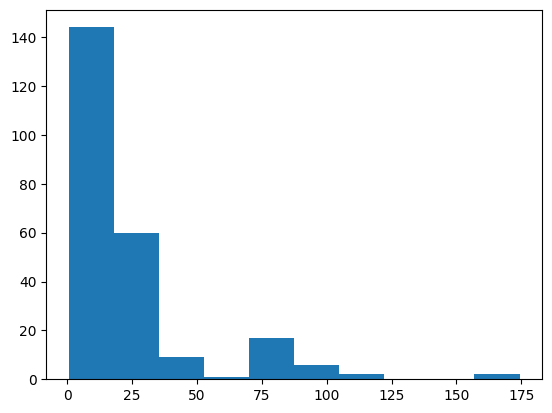

In [7]:
## Find median difference between timestamps over all tables and dates
timestamp_diffs = []
for date in data_egocentric:
    for table_name in data_egocentric[date]:
        timestamps = list(data_egocentric[date][table_name].keys())
        timestamps.sort()
        timestamp_diffs.extend(np.diff(timestamps))

print(f"Median timestamp difference: {np.median(timestamp_diffs)/60} minutes")
plt.hist(np.array(timestamp_diffs)/60)
plt.show()

## Generate graph sequences in SLaTe-PRO format with constant timestep

In [8]:
import torch

In [9]:
objects_masterlist = open("../../object_list.txt", "r").read().splitlines()
tables = [o for o in objects_masterlist if o.startswith("table")]
supplyshelf = [o for o in objects_masterlist if o.startswith("supply")]
surfaces = tables + supplyshelf
room = [o for o in objects_masterlist if o.startswith("room")]
objects = [o for o in objects_masterlist if o not in tables and o not in supplyshelf and o not in room]

print("Tables:", ', '.join(tables))
print("Supply Shelves:", ', '.join(supplyshelf))
print("Rooms:", ', '.join(room))
print("Objects:", ', '.join(objects))

static_graph_edges = torch.zeros(len(objects_masterlist), len(objects_masterlist), dtype=torch.float32)
active_edges_mask = torch.zeros_like(static_graph_edges, dtype=torch.float32)
for surface in tables + supplyshelf:
    static_graph_edges[objects_masterlist.index(surface), objects_masterlist.index("room")] = 1.0
    for object in objects:
        active_edges_mask[objects_masterlist.index(object), objects_masterlist.index(surface)] = 1.0


Tables: tableA, tableB, tableC, tableD, tableE
Supply Shelves: supplyshelf
Rooms: room
Objects: coasters, cup, etchpen, flower, foamball, gemset, glue, googlyeyes, keychain, moss, mossframe, paint, paintbrush, palette, photoframe, plantpot, stones, suncatcher, tissuebox, varnish


In [ ]:
dt = 10.0
print("Using dt: ", dt)
os.makedirs("processed_seqLM_coarse/all", exist_ok=True)

common_data = {
    'dt': dt,
    'start_time': 0.0,
    'end_time': 60*3,
    'node_classes': objects_masterlist,
    'node_categories': ['Rooms' if obj in room else 'Furniture' if obj in surfaces else 'placable_objects' for obj in objects_masterlist],
    'edge_keys': ["ON"],
    'static_nodes': [obj for obj in objects_masterlist if obj not in objects],
    'static_node_categories': ["Rooms", "Furniture"],
    'dataset_type': "RoboCraft",
    'n_stations': 5,
    'stations': ['tableA', 'tableB', 'tableC', 'tableD', 'tableE'],
    'dates': list(data_egocentric.keys())
}
json.dump(common_data, open("processed_seqLM_coarse/common_data.json", "w"), indent=4)

common_edge_data = {}
common_edge_data['home_graph'] = static_graph_edges.clone()
for obj in objects:
    common_edge_data['home_graph'][objects_masterlist.index(obj), objects_masterlist.index('room')] = 1.0
common_edge_data['nonstatic_edges'] = active_edges_mask.clone()
common_edge_data['seen_edges'] = torch.zeros_like(active_edges_mask, dtype=torch.float32)
torch.save(common_edge_data, "processed_seqLM_coarse/common_edge_data.pt")

common_embedding_map = {}


Using dt:  10.0


FileNotFoundError: [Errno 2] No such file or directory: 'processed_seqLM_coarse/common_data.json'

In [ ]:
def convert_to_slatepro_format(sg_egocentric):
    ## sg_egocentric is a dictionary of table_name -> list of objects
    sg_slatepro = torch.zeros(len(objects_masterlist), len(objects_masterlist), dtype=torch.float32)
    persons_per_table = torch.zeros((common_data['n_stations']), dtype=torch.float32)
    for table_name, objects in sg_egocentric.items():
        for object in objects:
            if object == "person":
                persons_per_table[common_data['stations'].index(table_name)] += 1
            else:
                sg_slatepro[objects_masterlist.index(object), objects_masterlist.index(table_name)] = 1.0
    for object in objects:
        sg_slatepro[objects_masterlist.index(object), objects_masterlist.index(supplyshelf[0])] = 1.0
        
    return sg_slatepro, persons_per_table


In [ ]:
import os

for date, data_egocentric_this_date in data_egocentric.items():
    nodes = torch.tensor([i for i in range(len(objects_masterlist))], dtype=torch.float32)
    times = torch.arange(common_data['start_time'], common_data['end_time'], common_data['dt'], dtype=torch.float32)
    scene_graph_list = []
    activity_list = []
    for timestamp_slatepro in times:
        sg_egocentric = {}
        VERBOSE and print(f"Timestamp: {timestamp_slatepro*60}")
        for table_name in common_data['stations']:
            if len(data_egocentric_this_date[table_name]) == 0:
                VERBOSE and print(f"{table_name}: No data")
                sg_egocentric[table_name] = []
                continue
            most_recent_timestamp = min(data_egocentric_this_date[table_name].keys(), key=lambda x: (abs(x - timestamp_slatepro*60) if (timestamp_slatepro*60 >= x) else float('inf')))
            if most_recent_timestamp > timestamp_slatepro*60:
                VERBOSE and print(f"{table_name}: No timestamp found")
                sg_egocentric[table_name] = []
            else:
                VERBOSE and print(f"{table_name}: Found {most_recent_timestamp/60}")
                sg_egocentric[table_name] = data_egocentric_this_date[table_name][most_recent_timestamp]
        sg, per = convert_to_slatepro_format(sg_egocentric)
        scene_graph_list.append(sg)
        activity_list.append(per)
        VERBOSE and print()
    torch.save({
            'nodes': nodes,
            'edges': torch.stack(scene_graph_list, dim=0),
            'times': times,
            'active_edges': active_edges_mask,
            'activity': torch.stack(activity_list, dim=0),
        }, f"processed_seqLM_coarse/all/{date}.pt")

    print(f"Written to processed_seqLM_coarse/all/{date}.pt")

## Temporary patches to test

In [ ]:
import shutil
shutil.copytree("processed_seqLM_coarse/all", "processed_seqLM_coarse/train")
shutil.copytree("processed_seqLM_coarse/all", "processed_seqLM_coarse/test")
